In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
data_df = pd.read_csv('simulation_sigmoidal.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
data_df

,sbj,trial,value_0,value_1,gaze_0,gaze_1,true_drift_0,true_drift_1,true_threshold,true_ndt,rt,choice
0,1,1,1.515307,5.702139,0.815368,0.184632,0.121320,1.248028,2.685671,0.795103,3.872103,1.0
1,1,2,5.800809,2.890693,0.057070,0.942930,0.368604,1.114728,2.685671,0.795103,4.199103,1.0
2,1,3,1.944349,5.512755,0.843520,0.156480,0.294848,0.969239,2.685671,0.795103,6.267103,0.0
3,1,4,3.209306,2.883418,0.287988,0.712012,0.287546,0.935792,2.685671,0.795103,2.464103,1.0
4,1,5,2.712884,5.816233,0.648374,0.351626,0.198987,1.571247,2.685671,0.795103,2.376103,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19969,100,196,5.225284,3.893592,0.069201,0.930799,0.280720,1.671857,2.387208,0.342712,2.245712,0.0
19970,100,197,1.903090,5.451513,0.860396,0.139604,0.267699,1.122338,2.387208,0.342712,1.828712,0.0
19971,100,198,5.879627,2.626809,0.333723,0.666277,1.663182,0.218219,2.387208,0.342712,1.650712,0.0
19972,100,199,1.102391,3.910916,0.890860,0.109140,0.172870,0.749631,2.387208,0.342712,1.477712,1.0


In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice']], dtype=np.float32)
X_train = np.asarray(tr_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']], dtype=np.float32)

obs_test = np.asarray(ts_df[['rt', 'choice']], dtype=np.float32)
X_test = np.asarray(ts_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']], dtype=np.float32)

print(X_train.shape, X_test.shape)

(13975, 4) (5999, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 312       
                                                                 
Total params: 605 (2.36 KB)
Trainable params: 605 (2.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 467s 467s/step - loss: 67473.7266
Epoch 2/3500
1/1 [==============================] - 0s 122ms/step - loss: 67177.5781
Epoch 3/3500
1/1 [==============================] - 0s 105ms/step - loss: 66970.5312
Epoch 4/3500
1/1 [==============================] - 0s 96ms/step - loss: 66799.6719
Epoch 5/3500
1/1 [==============================] - 0s 100ms/step - loss: 66648.4766
Epoch 6/3500
1/1 [==============================] - 0s 100ms/step - loss: 66509.7578
Epoch 7/3500
1/1 [==============================] - 0s 97ms/step - loss: 66379.8125
Epoch 8/3500
1/1 [==============================] - 0s 108ms/step - loss: 66256.3516
Epoch 9/3500
1/1 [==============================] - 0s 95ms/step - loss: 66137.8438
Epoch 10/3500
1/1 [==============================] - 0s 99ms/step - loss: 66023.2969
Epoch 11/3500
1/1 [==============================] - 0s 89ms/step - loss: 65912.0156
Epoch 12/3500
1/1 [==============================] - 0s 88ms/step -

1/1 [==============================] - 0s 124ms/step - loss: 59609.5312
Epoch 98/3500
1/1 [==============================] - 0s 130ms/step - loss: 59554.0547
Epoch 99/3500
1/1 [==============================] - 0s 123ms/step - loss: 59498.9023
Epoch 100/3500
1/1 [==============================] - 0s 124ms/step - loss: 59444.0781
Epoch 101/3500
1/1 [==============================] - 0s 124ms/step - loss: 59389.5781
Epoch 102/3500
1/1 [==============================] - 0s 128ms/step - loss: 59335.3906
Epoch 103/3500
1/1 [==============================] - 0s 132ms/step - loss: 59281.5273
Epoch 104/3500
1/1 [==============================] - 0s 130ms/step - loss: 59227.9805
Epoch 105/3500
1/1 [==============================] - 0s 128ms/step - loss: 59174.7500
Epoch 106/3500
1/1 [==============================] - 0s 128ms/step - loss: 59121.8242
Epoch 107/3500
1/1 [==============================] - 0s 127ms/step - loss: 59069.2109
Epoch 108/3500
1/1 [==============================] - 0s 128

1/1 [==============================] - 0s 132ms/step - loss: 55526.6719
Epoch 192/3500
1/1 [==============================] - 0s 132ms/step - loss: 55492.5352
Epoch 193/3500
1/1 [==============================] - 0s 144ms/step - loss: 55458.5469
Epoch 194/3500
1/1 [==============================] - 0s 128ms/step - loss: 55424.6953
Epoch 195/3500
1/1 [==============================] - 0s 130ms/step - loss: 55390.9805
Epoch 196/3500
1/1 [==============================] - 0s 126ms/step - loss: 55357.3984
Epoch 197/3500
1/1 [==============================] - 0s 126ms/step - loss: 55323.9531
Epoch 198/3500
1/1 [==============================] - 0s 128ms/step - loss: 55290.6406
Epoch 199/3500
1/1 [==============================] - 0s 126ms/step - loss: 55257.4609
Epoch 200/3500
1/1 [==============================] - 0s 123ms/step - loss: 55224.4180
Epoch 201/3500
1/1 [==============================] - 0s 125ms/step - loss: 55191.4922
Epoch 202/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 124ms/step - loss: 52704.0156
Epoch 286/3500
1/1 [==============================] - 0s 124ms/step - loss: 52675.5586
Epoch 287/3500
1/1 [==============================] - 0s 122ms/step - loss: 52647.0898
Epoch 288/3500
1/1 [==============================] - 0s 124ms/step - loss: 52618.5938
Epoch 289/3500
1/1 [==============================] - 0s 125ms/step - loss: 52590.0664
Epoch 290/3500
1/1 [==============================] - 0s 124ms/step - loss: 52561.5078
Epoch 291/3500
1/1 [==============================] - 0s 123ms/step - loss: 52532.9219
Epoch 292/3500
1/1 [==============================] - 0s 123ms/step - loss: 52504.2891
Epoch 293/3500
1/1 [==============================] - 0s 130ms/step - loss: 52475.6133
Epoch 294/3500
1/1 [==============================] - 0s 125ms/step - loss: 52446.8984
Epoch 295/3500
1/1 [==============================] - 0s 124ms/step - loss: 52418.1328
Epoch 296/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 130ms/step - loss: 49635.8984
Epoch 380/3500
1/1 [==============================] - 0s 123ms/step - loss: 49596.0586
Epoch 381/3500
1/1 [==============================] - 0s 123ms/step - loss: 49555.9688
Epoch 382/3500
1/1 [==============================] - 0s 122ms/step - loss: 49515.6133
Epoch 383/3500
1/1 [==============================] - 0s 122ms/step - loss: 49474.9648
Epoch 384/3500
1/1 [==============================] - 0s 124ms/step - loss: 49433.9844
Epoch 385/3500
1/1 [==============================] - 0s 126ms/step - loss: 49392.6875
Epoch 386/3500
1/1 [==============================] - 0s 122ms/step - loss: 49351.0234
Epoch 387/3500
1/1 [==============================] - 0s 122ms/step - loss: 49308.9844
Epoch 388/3500
1/1 [==============================] - 0s 124ms/step - loss: 49266.5391
Epoch 389/3500
1/1 [==============================] - 0s 122ms/step - loss: 49223.6758
Epoch 390/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 124ms/step - loss: 45188.7109
Epoch 474/3500
1/1 [==============================] - 0s 123ms/step - loss: 45145.5469
Epoch 475/3500
1/1 [==============================] - 0s 127ms/step - loss: 45102.4766
Epoch 476/3500
1/1 [==============================] - 0s 124ms/step - loss: 45059.4844
Epoch 477/3500
1/1 [==============================] - 0s 125ms/step - loss: 45016.5898
Epoch 478/3500
1/1 [==============================] - 0s 125ms/step - loss: 44973.7461
Epoch 479/3500
1/1 [==============================] - 0s 121ms/step - loss: 44931.0117
Epoch 480/3500
1/1 [==============================] - 0s 125ms/step - loss: 44888.3320
Epoch 481/3500
1/1 [==============================] - 0s 123ms/step - loss: 44845.7656
Epoch 482/3500
1/1 [==============================] - 0s 126ms/step - loss: 44803.2461
Epoch 483/3500
1/1 [==============================] - 0s 124ms/step - loss: 44760.8398
Epoch 484/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 125ms/step - loss: 41514.4961
Epoch 568/3500
1/1 [==============================] - 0s 125ms/step - loss: 41480.6445
Epoch 569/3500
1/1 [==============================] - 0s 125ms/step - loss: 41447.0000
Epoch 570/3500
1/1 [==============================] - 0s 125ms/step - loss: 41413.4297
Epoch 571/3500
1/1 [==============================] - 0s 123ms/step - loss: 41380.0586
Epoch 572/3500
1/1 [==============================] - 0s 124ms/step - loss: 41346.7656
Epoch 573/3500
1/1 [==============================] - 0s 124ms/step - loss: 41313.6641
Epoch 574/3500
1/1 [==============================] - 0s 125ms/step - loss: 41280.6406
Epoch 575/3500
1/1 [==============================] - 0s 124ms/step - loss: 41247.8086
Epoch 576/3500
1/1 [==============================] - 0s 124ms/step - loss: 41215.0547
Epoch 577/3500
1/1 [==============================] - 0s 125ms/step - loss: 41182.4883
Epoch 578/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 122ms/step - loss: 38791.8477
Epoch 662/3500
1/1 [==============================] - 0s 123ms/step - loss: 38766.3281
Epoch 663/3500
1/1 [==============================] - 0s 124ms/step - loss: 38740.7930
Epoch 664/3500
1/1 [==============================] - 0s 123ms/step - loss: 38715.3789
Epoch 665/3500
1/1 [==============================] - 0s 124ms/step - loss: 38689.9492
Epoch 666/3500
1/1 [==============================] - 0s 123ms/step - loss: 38664.6328
Epoch 667/3500
1/1 [==============================] - 0s 122ms/step - loss: 38639.3047
Epoch 668/3500
1/1 [==============================] - 0s 123ms/step - loss: 38614.0938
Epoch 669/3500
1/1 [==============================] - 0s 125ms/step - loss: 38588.8555
Epoch 670/3500
1/1 [==============================] - 0s 124ms/step - loss: 38563.7422
Epoch 671/3500
1/1 [==============================] - 0s 124ms/step - loss: 38538.6094
Epoch 672/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 124ms/step - loss: 36581.3359
Epoch 756/3500
1/1 [==============================] - 0s 124ms/step - loss: 36559.6484
Epoch 757/3500
1/1 [==============================] - 0s 123ms/step - loss: 36537.9453
Epoch 758/3500
1/1 [==============================] - 0s 122ms/step - loss: 36516.3242
Epoch 759/3500
1/1 [==============================] - 0s 125ms/step - loss: 36494.6953
Epoch 760/3500
1/1 [==============================] - 0s 123ms/step - loss: 36473.1406
Epoch 761/3500
1/1 [==============================] - 0s 123ms/step - loss: 36451.5859
Epoch 762/3500
1/1 [==============================] - 0s 125ms/step - loss: 36430.1055
Epoch 763/3500
1/1 [==============================] - 0s 132ms/step - loss: 36408.6133
Epoch 764/3500
1/1 [==============================] - 0s 130ms/step - loss: 36387.1992
Epoch 765/3500
1/1 [==============================] - 0s 127ms/step - loss: 36365.7812
Epoch 766/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 127ms/step - loss: 34699.5391
Epoch 850/3500
1/1 [==============================] - 0s 129ms/step - loss: 34681.3203
Epoch 851/3500
1/1 [==============================] - 0s 129ms/step - loss: 34663.0938
Epoch 852/3500
1/1 [==============================] - 0s 127ms/step - loss: 34644.9453
Epoch 853/3500
1/1 [==============================] - 0s 127ms/step - loss: 34626.7891
Epoch 854/3500
1/1 [==============================] - 0s 126ms/step - loss: 34608.7148
Epoch 855/3500
1/1 [==============================] - 0s 128ms/step - loss: 34590.6250
Epoch 856/3500
1/1 [==============================] - 0s 131ms/step - loss: 34572.6211
Epoch 857/3500
1/1 [==============================] - 0s 131ms/step - loss: 34554.6016
Epoch 858/3500
1/1 [==============================] - 0s 149ms/step - loss: 34536.6719
Epoch 859/3500
1/1 [==============================] - 0s 132ms/step - loss: 34518.7188
Epoch 860/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 125ms/step - loss: 33127.9141
Epoch 944/3500
1/1 [==============================] - 0s 122ms/step - loss: 33112.7188
Epoch 945/3500
1/1 [==============================] - 0s 124ms/step - loss: 33097.4453
Epoch 946/3500
1/1 [==============================] - 0s 123ms/step - loss: 33082.2969
Epoch 947/3500
1/1 [==============================] - 0s 122ms/step - loss: 33067.0898
Epoch 948/3500
1/1 [==============================] - 0s 122ms/step - loss: 33051.9883
Epoch 949/3500
1/1 [==============================] - 0s 125ms/step - loss: 33036.8438
Epoch 950/3500
1/1 [==============================] - 0s 124ms/step - loss: 33021.8047
Epoch 951/3500
1/1 [==============================] - 0s 125ms/step - loss: 33006.7070
Epoch 952/3500
1/1 [==============================] - 0s 122ms/step - loss: 32991.7422
Epoch 953/3500
1/1 [==============================] - 0s 123ms/step - loss: 32976.6992
Epoch 954/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 124ms/step - loss: 31834.8281
Epoch 1037/3500
1/1 [==============================] - 0s 121ms/step - loss: 31821.9688
Epoch 1038/3500
1/1 [==============================] - 0s 123ms/step - loss: 31809.1602
Epoch 1039/3500
1/1 [==============================] - 0s 126ms/step - loss: 31795.3594
Epoch 1040/3500
1/1 [==============================] - 0s 124ms/step - loss: 31782.3281
Epoch 1041/3500
1/1 [==============================] - 0s 126ms/step - loss: 31769.2109
Epoch 1042/3500
1/1 [==============================] - 0s 123ms/step - loss: 31756.9648
Epoch 1043/3500
1/1 [==============================] - 0s 124ms/step - loss: 31745.1445
Epoch 1044/3500
1/1 [==============================] - 0s 124ms/step - loss: 31734.1836
Epoch 1045/3500
1/1 [==============================] - 0s 125ms/step - loss: 31723.5176
Epoch 1046/3500
1/1 [==============================] - 0s 123ms/step - loss: 31711.3809
Epoch 1047/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 30771.1230
Epoch 1130/3500
1/1 [==============================] - 0s 132ms/step - loss: 30759.8906
Epoch 1131/3500
1/1 [==============================] - 0s 126ms/step - loss: 30748.5195
Epoch 1132/3500
1/1 [==============================] - 0s 123ms/step - loss: 30738.3496
Epoch 1133/3500
1/1 [==============================] - 0s 124ms/step - loss: 30728.3691
Epoch 1134/3500
1/1 [==============================] - 0s 122ms/step - loss: 30719.6719
Epoch 1135/3500
1/1 [==============================] - 0s 123ms/step - loss: 30712.5293
Epoch 1136/3500
1/1 [==============================] - 0s 122ms/step - loss: 30706.0918
Epoch 1137/3500
1/1 [==============================] - 0s 123ms/step - loss: 30696.9570
Epoch 1138/3500
1/1 [==============================] - 0s 124ms/step - loss: 30683.5859
Epoch 1139/3500
1/1 [==============================] - 0s 124ms/step - loss: 30670.5801
Epoch 1140/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 29919.6758
Epoch 1223/3500
1/1 [==============================] - 0s 124ms/step - loss: 29912.3809
Epoch 1224/3500
1/1 [==============================] - 0s 125ms/step - loss: 29906.9531
Epoch 1225/3500
1/1 [==============================] - 0s 123ms/step - loss: 29901.2305
Epoch 1226/3500
1/1 [==============================] - 0s 124ms/step - loss: 29896.0312
Epoch 1227/3500
1/1 [==============================] - 0s 125ms/step - loss: 29887.2656
Epoch 1228/3500
1/1 [==============================] - 0s 126ms/step - loss: 29877.6465
Epoch 1229/3500
1/1 [==============================] - 0s 127ms/step - loss: 29867.0176
Epoch 1230/3500
1/1 [==============================] - 0s 124ms/step - loss: 29858.1484
Epoch 1231/3500
1/1 [==============================] - 0s 123ms/step - loss: 29848.7520
Epoch 1232/3500
1/1 [==============================] - 0s 122ms/step - loss: 29840.7812
Epoch 1233/3500
1/1 [===========================

1/1 [==============================] - 0s 123ms/step - loss: 29263.9883
Epoch 1316/3500
1/1 [==============================] - 0s 125ms/step - loss: 29258.8125
Epoch 1317/3500
1/1 [==============================] - 0s 124ms/step - loss: 29251.9219
Epoch 1318/3500
1/1 [==============================] - 0s 124ms/step - loss: 29244.0957
Epoch 1319/3500
1/1 [==============================] - 0s 125ms/step - loss: 29239.2852
Epoch 1320/3500
1/1 [==============================] - 0s 121ms/step - loss: 29234.4629
Epoch 1321/3500
1/1 [==============================] - 0s 121ms/step - loss: 29230.5000
Epoch 1322/3500
1/1 [==============================] - 0s 125ms/step - loss: 29230.8828
Epoch 1323/3500
1/1 [==============================] - 0s 125ms/step - loss: 29231.1074
Epoch 1324/3500
1/1 [==============================] - 0s 122ms/step - loss: 29227.2012
Epoch 1325/3500
1/1 [==============================] - 0s 121ms/step - loss: 29214.4434
Epoch 1326/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 28784.2402
Epoch 1409/3500
1/1 [==============================] - 0s 123ms/step - loss: 28781.6309
Epoch 1410/3500
1/1 [==============================] - 0s 124ms/step - loss: 28772.9023
Epoch 1411/3500
1/1 [==============================] - 0s 125ms/step - loss: 28757.8164
Epoch 1412/3500
1/1 [==============================] - 0s 128ms/step - loss: 28748.0605
Epoch 1413/3500
1/1 [==============================] - 0s 125ms/step - loss: 28739.8535
Epoch 1414/3500
1/1 [==============================] - 0s 120ms/step - loss: 28734.5938
Epoch 1415/3500
1/1 [==============================] - 0s 127ms/step - loss: 28729.6230
Epoch 1416/3500
1/1 [==============================] - 0s 123ms/step - loss: 28724.3184
Epoch 1417/3500
1/1 [==============================] - 0s 121ms/step - loss: 28721.7637
Epoch 1418/3500
1/1 [==============================] - 0s 125ms/step - loss: 28718.0703
Epoch 1419/3500
1/1 [===========================

1/1 [==============================] - 0s 134ms/step - loss: 28395.5801
Epoch 1502/3500
1/1 [==============================] - 0s 132ms/step - loss: 28392.1289
Epoch 1503/3500
1/1 [==============================] - 0s 128ms/step - loss: 28389.5547
Epoch 1504/3500
1/1 [==============================] - 0s 126ms/step - loss: 28389.2812
Epoch 1505/3500
1/1 [==============================] - 0s 128ms/step - loss: 28387.8867
Epoch 1506/3500
1/1 [==============================] - 0s 136ms/step - loss: 28389.1992
Epoch 1507/3500
1/1 [==============================] - 0s 136ms/step - loss: 28391.1016
Epoch 1508/3500
1/1 [==============================] - 0s 137ms/step - loss: 28389.4336
Epoch 1509/3500
1/1 [==============================] - 0s 137ms/step - loss: 28384.7734
Epoch 1510/3500
1/1 [==============================] - 0s 133ms/step - loss: 28381.7441
Epoch 1511/3500
1/1 [==============================] - 0s 130ms/step - loss: 28376.7207
Epoch 1512/3500
1/1 [===========================

1/1 [==============================] - 0s 141ms/step - loss: 28167.2148
Epoch 1595/3500
1/1 [==============================] - 0s 131ms/step - loss: 28161.4629
Epoch 1596/3500
1/1 [==============================] - 0s 130ms/step - loss: 28152.5488
Epoch 1597/3500
1/1 [==============================] - 0s 131ms/step - loss: 28138.3828
Epoch 1598/3500
1/1 [==============================] - 0s 131ms/step - loss: 28130.1289
Epoch 1599/3500
1/1 [==============================] - 0s 126ms/step - loss: 28124.4277
Epoch 1600/3500
1/1 [==============================] - 0s 130ms/step - loss: 28119.1484
Epoch 1601/3500
1/1 [==============================] - 0s 130ms/step - loss: 28116.4199
Epoch 1602/3500
1/1 [==============================] - 0s 127ms/step - loss: 28114.1191
Epoch 1603/3500
1/1 [==============================] - 0s 123ms/step - loss: 28111.9668
Epoch 1604/3500
1/1 [==============================] - 0s 125ms/step - loss: 28110.6895
Epoch 1605/3500
1/1 [===========================

1/1 [==============================] - 0s 123ms/step - loss: 27940.1426
Epoch 1688/3500
1/1 [==============================] - 0s 123ms/step - loss: 27939.0312
Epoch 1689/3500
1/1 [==============================] - 0s 124ms/step - loss: 27936.8066
Epoch 1690/3500
1/1 [==============================] - 0s 123ms/step - loss: 27937.1367
Epoch 1691/3500
1/1 [==============================] - 0s 125ms/step - loss: 27937.0586
Epoch 1692/3500
1/1 [==============================] - 0s 124ms/step - loss: 27934.8691
Epoch 1693/3500
1/1 [==============================] - 0s 125ms/step - loss: 27935.3125
Epoch 1694/3500
1/1 [==============================] - 0s 122ms/step - loss: 27933.5781
Epoch 1695/3500
1/1 [==============================] - 0s 125ms/step - loss: 27935.0000
Epoch 1696/3500
1/1 [==============================] - 0s 125ms/step - loss: 27937.6367
Epoch 1697/3500
1/1 [==============================] - 0s 125ms/step - loss: 27934.5391
Epoch 1698/3500
1/1 [===========================

1/1 [==============================] - 0s 126ms/step - loss: 27789.2129
Epoch 1781/3500
1/1 [==============================] - 0s 123ms/step - loss: 27788.4609
Epoch 1782/3500
1/1 [==============================] - 0s 124ms/step - loss: 27785.5293
Epoch 1783/3500
1/1 [==============================] - 0s 125ms/step - loss: 27785.0410
Epoch 1784/3500
1/1 [==============================] - 0s 124ms/step - loss: 27781.0625
Epoch 1785/3500
1/1 [==============================] - 0s 124ms/step - loss: 27788.0703
Epoch 1786/3500
1/1 [==============================] - 0s 124ms/step - loss: 27813.5430
Epoch 1787/3500
1/1 [==============================] - 0s 124ms/step - loss: 27817.4883
Epoch 1788/3500
1/1 [==============================] - 0s 124ms/step - loss: 27805.0352
Epoch 1789/3500
1/1 [==============================] - 0s 122ms/step - loss: 27785.3066
Epoch 1790/3500
1/1 [==============================] - 0s 124ms/step - loss: 27775.2656
Epoch 1791/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 27664.8594
Epoch 1874/3500
1/1 [==============================] - 0s 125ms/step - loss: 27672.6562
Epoch 1875/3500
1/1 [==============================] - 0s 121ms/step - loss: 27670.5703
Epoch 1876/3500
1/1 [==============================] - 0s 122ms/step - loss: 27666.7051
Epoch 1877/3500
1/1 [==============================] - 0s 125ms/step - loss: 27662.3477
Epoch 1878/3500
1/1 [==============================] - 0s 125ms/step - loss: 27658.7637
Epoch 1879/3500
1/1 [==============================] - 0s 126ms/step - loss: 27655.6621
Epoch 1880/3500
1/1 [==============================] - 0s 125ms/step - loss: 27652.0566
Epoch 1881/3500
1/1 [==============================] - 0s 123ms/step - loss: 27651.7188
Epoch 1882/3500
1/1 [==============================] - 0s 122ms/step - loss: 27649.8730
Epoch 1883/3500
1/1 [==============================] - 0s 123ms/step - loss: 27650.2754
Epoch 1884/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 27558.5059
Epoch 1967/3500
1/1 [==============================] - 0s 128ms/step - loss: 27558.5703
Epoch 1968/3500
1/1 [==============================] - 0s 128ms/step - loss: 27559.2148
Epoch 1969/3500
1/1 [==============================] - 0s 126ms/step - loss: 27564.4297
Epoch 1970/3500
1/1 [==============================] - 0s 125ms/step - loss: 27560.7617
Epoch 1971/3500
1/1 [==============================] - 0s 124ms/step - loss: 27562.6191
Epoch 1972/3500
1/1 [==============================] - 0s 123ms/step - loss: 27558.8184
Epoch 1973/3500
1/1 [==============================] - 0s 124ms/step - loss: 27559.2520
Epoch 1974/3500
1/1 [==============================] - 0s 123ms/step - loss: 27564.4609
Epoch 1975/3500
1/1 [==============================] - 0s 128ms/step - loss: 27582.6973
Epoch 1976/3500
1/1 [==============================] - 0s 124ms/step - loss: 27600.9316
Epoch 1977/3500
1/1 [===========================

1/1 [==============================] - 0s 126ms/step - loss: 27490.9727
Epoch 2060/3500
1/1 [==============================] - 0s 124ms/step - loss: 27494.8301
Epoch 2061/3500
1/1 [==============================] - 0s 125ms/step - loss: 27492.0117
Epoch 2062/3500
1/1 [==============================] - 0s 120ms/step - loss: 27487.8320
Epoch 2063/3500
1/1 [==============================] - 0s 125ms/step - loss: 27480.5234
Epoch 2064/3500
1/1 [==============================] - 0s 124ms/step - loss: 27476.8340
Epoch 2065/3500
1/1 [==============================] - 0s 125ms/step - loss: 27472.9141
Epoch 2066/3500
1/1 [==============================] - 0s 124ms/step - loss: 27471.4766
Epoch 2067/3500
1/1 [==============================] - 0s 125ms/step - loss: 27470.7129
Epoch 2068/3500
1/1 [==============================] - 0s 125ms/step - loss: 27471.7812
Epoch 2069/3500
1/1 [==============================] - 0s 124ms/step - loss: 27469.6680
Epoch 2070/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 27426.3770
Epoch 2153/3500
1/1 [==============================] - 0s 128ms/step - loss: 27420.0762
Epoch 2154/3500
1/1 [==============================] - 0s 125ms/step - loss: 27412.3848
Epoch 2155/3500
1/1 [==============================] - 0s 123ms/step - loss: 27405.2891
Epoch 2156/3500
1/1 [==============================] - 0s 125ms/step - loss: 27405.7031
Epoch 2157/3500
1/1 [==============================] - 0s 125ms/step - loss: 27396.2324
Epoch 2158/3500
1/1 [==============================] - 0s 125ms/step - loss: 27395.8340
Epoch 2159/3500
1/1 [==============================] - 0s 121ms/step - loss: 27394.1973
Epoch 2160/3500
1/1 [==============================] - 0s 127ms/step - loss: 27394.2031
Epoch 2161/3500
1/1 [==============================] - 0s 123ms/step - loss: 27396.5859
Epoch 2162/3500
1/1 [==============================] - 0s 126ms/step - loss: 27398.0000
Epoch 2163/3500
1/1 [===========================

1/1 [==============================] - 0s 123ms/step - loss: 27344.2500
Epoch 2246/3500
1/1 [==============================] - 0s 130ms/step - loss: 27345.3477
Epoch 2247/3500
1/1 [==============================] - 0s 131ms/step - loss: 27347.5723
Epoch 2248/3500
1/1 [==============================] - 0s 130ms/step - loss: 27351.9355
Epoch 2249/3500
1/1 [==============================] - 0s 128ms/step - loss: 27364.3027
Epoch 2250/3500
1/1 [==============================] - 0s 129ms/step - loss: 27388.5703
Epoch 2251/3500
1/1 [==============================] - 0s 132ms/step - loss: 27403.7578
Epoch 2252/3500
1/1 [==============================] - 0s 136ms/step - loss: 27370.2070
Epoch 2253/3500
1/1 [==============================] - 0s 131ms/step - loss: 27353.9570
Epoch 2254/3500
1/1 [==============================] - 0s 132ms/step - loss: 27340.6973
Epoch 2255/3500
1/1 [==============================] - 0s 132ms/step - loss: 27338.0703
Epoch 2256/3500
1/1 [===========================

1/1 [==============================] - 0s 130ms/step - loss: 27317.1367
Epoch 2339/3500
1/1 [==============================] - 0s 126ms/step - loss: 27307.1172
Epoch 2340/3500
1/1 [==============================] - 0s 132ms/step - loss: 27301.9219
Epoch 2341/3500
1/1 [==============================] - 0s 130ms/step - loss: 27297.3242
Epoch 2342/3500
1/1 [==============================] - 0s 125ms/step - loss: 27299.0508
Epoch 2343/3500
1/1 [==============================] - 0s 124ms/step - loss: 27295.3496
Epoch 2344/3500
1/1 [==============================] - 0s 125ms/step - loss: 27297.1035
Epoch 2345/3500
1/1 [==============================] - 0s 125ms/step - loss: 27302.6895
Epoch 2346/3500
1/1 [==============================] - 0s 125ms/step - loss: 27310.9434
Epoch 2347/3500
1/1 [==============================] - 0s 124ms/step - loss: 27316.3945
Epoch 2348/3500
1/1 [==============================] - 0s 122ms/step - loss: 27310.2832
Epoch 2349/3500
1/1 [===========================

1/1 [==============================] - 0s 128ms/step - loss: 27262.1914
Epoch 2432/3500
1/1 [==============================] - 0s 126ms/step - loss: 27264.2812
Epoch 2433/3500
1/1 [==============================] - 0s 125ms/step - loss: 27263.1797
Epoch 2434/3500
1/1 [==============================] - 0s 126ms/step - loss: 27266.1230
Epoch 2435/3500
1/1 [==============================] - 0s 123ms/step - loss: 27262.5625
Epoch 2436/3500
1/1 [==============================] - 0s 125ms/step - loss: 27262.9668
Epoch 2437/3500
1/1 [==============================] - 0s 123ms/step - loss: 27260.2305
Epoch 2438/3500
1/1 [==============================] - 0s 122ms/step - loss: 27261.9629
Epoch 2439/3500
1/1 [==============================] - 0s 123ms/step - loss: 27261.3125
Epoch 2440/3500
1/1 [==============================] - 0s 126ms/step - loss: 27263.7559
Epoch 2441/3500
1/1 [==============================] - 0s 125ms/step - loss: 27265.8145
Epoch 2442/3500
1/1 [===========================

1/1 [==============================] - 0s 121ms/step - loss: 27242.0391
Epoch 2525/3500
1/1 [==============================] - 0s 123ms/step - loss: 27247.8984
Epoch 2526/3500
1/1 [==============================] - 0s 122ms/step - loss: 27251.4238
Epoch 2527/3500
1/1 [==============================] - 0s 125ms/step - loss: 27245.6797
Epoch 2528/3500
1/1 [==============================] - 0s 124ms/step - loss: 27240.9688
Epoch 2529/3500
1/1 [==============================] - 0s 124ms/step - loss: 27230.3125
Epoch 2530/3500
1/1 [==============================] - 0s 121ms/step - loss: 27226.0703
Epoch 2531/3500
1/1 [==============================] - 0s 126ms/step - loss: 27223.2773
Epoch 2532/3500
1/1 [==============================] - 0s 124ms/step - loss: 27222.0000
Epoch 2533/3500
1/1 [==============================] - 0s 125ms/step - loss: 27220.8340
Epoch 2534/3500
1/1 [==============================] - 0s 126ms/step - loss: 27220.7441
Epoch 2535/3500
1/1 [===========================

1/1 [==============================] - 0s 126ms/step - loss: 27203.9805
Epoch 2618/3500
1/1 [==============================] - 0s 127ms/step - loss: 27209.2539
Epoch 2619/3500
1/1 [==============================] - 0s 126ms/step - loss: 27212.2500
Epoch 2620/3500
1/1 [==============================] - 0s 125ms/step - loss: 27224.1504
Epoch 2621/3500
1/1 [==============================] - 0s 126ms/step - loss: 27241.0508
Epoch 2622/3500
1/1 [==============================] - 0s 124ms/step - loss: 27247.0625
Epoch 2623/3500
1/1 [==============================] - 0s 125ms/step - loss: 27228.7148
Epoch 2624/3500
1/1 [==============================] - 0s 124ms/step - loss: 27209.9102
Epoch 2625/3500
1/1 [==============================] - 0s 124ms/step - loss: 27197.9258
Epoch 2626/3500
1/1 [==============================] - 0s 122ms/step - loss: 27195.4355
Epoch 2627/3500
1/1 [==============================] - 0s 123ms/step - loss: 27194.5723
Epoch 2628/3500
1/1 [===========================

1/1 [==============================] - 0s 127ms/step - loss: 27183.4766
Epoch 2711/3500
1/1 [==============================] - 0s 125ms/step - loss: 27179.5977
Epoch 2712/3500
1/1 [==============================] - 0s 128ms/step - loss: 27177.0234
Epoch 2713/3500
1/1 [==============================] - 0s 126ms/step - loss: 27182.1309
Epoch 2714/3500
1/1 [==============================] - 0s 130ms/step - loss: 27197.5215
Epoch 2715/3500
1/1 [==============================] - 0s 133ms/step - loss: 27206.8359
Epoch 2716/3500
1/1 [==============================] - 0s 127ms/step - loss: 27210.1113
Epoch 2717/3500
1/1 [==============================] - 0s 150ms/step - loss: 27202.9492
Epoch 2718/3500
1/1 [==============================] - 0s 203ms/step - loss: 27404.7910
Epoch 2719/3500
1/1 [==============================] - 0s 132ms/step - loss: 27224.8125
Epoch 2720/3500
1/1 [==============================] - 0s 236ms/step - loss: 27173.8867
Epoch 2721/3500
1/1 [===========================

1/1 [==============================] - 0s 194ms/step - loss: 27159.0371
Epoch 2804/3500
1/1 [==============================] - 0s 256ms/step - loss: 27162.1602
Epoch 2805/3500
1/1 [==============================] - 0s 139ms/step - loss: 27159.5039
Epoch 2806/3500
1/1 [==============================] - 0s 134ms/step - loss: 27163.0000
Epoch 2807/3500
1/1 [==============================] - 0s 133ms/step - loss: 27164.0898
Epoch 2808/3500
1/1 [==============================] - 0s 129ms/step - loss: 27169.4863
Epoch 2809/3500
1/1 [==============================] - 0s 189ms/step - loss: 27174.3574
Epoch 2810/3500
1/1 [==============================] - 0s 142ms/step - loss: 27178.1250
Epoch 2811/3500
1/1 [==============================] - 0s 132ms/step - loss: 27179.7910
Epoch 2812/3500
1/1 [==============================] - 0s 129ms/step - loss: 27198.3340
Epoch 2813/3500
1/1 [==============================] - 0s 175ms/step - loss: 27239.9082
Epoch 2814/3500
1/1 [===========================

1/1 [==============================] - 0s 140ms/step - loss: 27162.4297
Epoch 2897/3500
1/1 [==============================] - 0s 139ms/step - loss: 27153.8652
Epoch 2898/3500
1/1 [==============================] - 0s 131ms/step - loss: 27147.5254
Epoch 2899/3500
1/1 [==============================] - 0s 131ms/step - loss: 27145.6738
Epoch 2900/3500
1/1 [==============================] - 0s 128ms/step - loss: 27147.6367
Epoch 2901/3500
1/1 [==============================] - 0s 133ms/step - loss: 27152.0469
Epoch 2902/3500
1/1 [==============================] - 0s 128ms/step - loss: 27156.4922
Epoch 2903/3500
1/1 [==============================] - 0s 130ms/step - loss: 27163.1562
Epoch 2904/3500
1/1 [==============================] - 0s 132ms/step - loss: 27163.5488
Epoch 2905/3500
1/1 [==============================] - 0s 134ms/step - loss: 27165.1719
Epoch 2906/3500
1/1 [==============================] - 0s 129ms/step - loss: 27157.2188
Epoch 2907/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 27148.1445
Epoch 2990/3500
1/1 [==============================] - 0s 135ms/step - loss: 27149.7734
Epoch 2991/3500
1/1 [==============================] - 0s 131ms/step - loss: 27149.2871
Epoch 2992/3500
1/1 [==============================] - 0s 132ms/step - loss: nan
Epoch 2993/3500
1/1 [==============================] - 0s 127ms/step - loss: 27135.8516
Epoch 2994/3500
1/1 [==============================] - 0s 124ms/step - loss: 27134.5605
Epoch 2995/3500
1/1 [==============================] - 0s 133ms/step - loss: 27137.9258
Epoch 2996/3500
1/1 [==============================] - 0s 132ms/step - loss: 27136.6562
Epoch 2997/3500
1/1 [==============================] - 0s 130ms/step - loss: 27138.7910
Epoch 2998/3500
1/1 [==============================] - 0s 121ms/step - loss: 27152.5918
Epoch 2999/3500
1/1 [==============================] - 0s 125ms/step - loss: 27174.4453
Epoch 3000/3500
1/1 [==============================] - 

1/1 [==============================] - 0s 127ms/step - loss: 27136.9316
Epoch 3083/3500
1/1 [==============================] - 0s 130ms/step - loss: 27135.2188
Epoch 3084/3500
1/1 [==============================] - 0s 123ms/step - loss: 27134.0723
Epoch 3085/3500
1/1 [==============================] - 0s 124ms/step - loss: 27135.1816
Epoch 3086/3500
1/1 [==============================] - 0s 128ms/step - loss: 27137.0859
Epoch 3087/3500
1/1 [==============================] - 0s 123ms/step - loss: nan
Epoch 3088/3500
1/1 [==============================] - 0s 129ms/step - loss: 27128.5586
Epoch 3089/3500
1/1 [==============================] - 0s 124ms/step - loss: 27126.7891
Epoch 3090/3500
1/1 [==============================] - 0s 128ms/step - loss: 27131.6992
Epoch 3091/3500
1/1 [==============================] - 0s 130ms/step - loss: 27147.1758
Epoch 3092/3500
1/1 [==============================] - 0s 127ms/step - loss: 27174.6562
Epoch 3093/3500
1/1 [==============================] - 

1/1 [==============================] - 0s 126ms/step - loss: 27135.3672
Epoch 3176/3500
1/1 [==============================] - 0s 125ms/step - loss: 27137.3984
Epoch 3177/3500
1/1 [==============================] - 0s 124ms/step - loss: 27157.4512
Epoch 3178/3500
1/1 [==============================] - 0s 121ms/step - loss: 27147.7246
Epoch 3179/3500
1/1 [==============================] - 0s 126ms/step - loss: 27141.0742
Epoch 3180/3500
1/1 [==============================] - 0s 124ms/step - loss: 27128.2832
Epoch 3181/3500
1/1 [==============================] - 0s 126ms/step - loss: 27126.7930
Epoch 3182/3500
1/1 [==============================] - 0s 124ms/step - loss: 27120.5293
Epoch 3183/3500
1/1 [==============================] - 0s 125ms/step - loss: 27125.3652
Epoch 3184/3500
1/1 [==============================] - 0s 124ms/step - loss: 27118.2344
Epoch 3185/3500
1/1 [==============================] - 0s 127ms/step - loss: 27128.9590
Epoch 3186/3500
1/1 [===========================

1/1 [==============================] - 0s 127ms/step - loss: 27126.8125
Epoch 3269/3500
1/1 [==============================] - 0s 173ms/step - loss: 27124.3945
Epoch 3270/3500
1/1 [==============================] - 0s 122ms/step - loss: 27131.9297
Epoch 3271/3500
1/1 [==============================] - 0s 126ms/step - loss: 27169.7324
Epoch 3272/3500
1/1 [==============================] - 0s 125ms/step - loss: nan
Epoch 3273/3500
1/1 [==============================] - 0s 121ms/step - loss: 27150.0762
Epoch 3274/3500
1/1 [==============================] - 0s 124ms/step - loss: 27131.6172
Epoch 3275/3500
1/1 [==============================] - 0s 122ms/step - loss: 27128.4102
Epoch 3276/3500
1/1 [==============================] - 0s 125ms/step - loss: 27124.2520
Epoch 3277/3500
1/1 [==============================] - 0s 124ms/step - loss: 27127.1289
Epoch 3278/3500
1/1 [==============================] - 0s 130ms/step - loss: 27128.0352
Epoch 3279/3500
1/1 [==============================] - 

1/1 [==============================] - 0s 137ms/step - loss: 27122.9922
Epoch 3362/3500
1/1 [==============================] - 0s 128ms/step - loss: 27115.6816
Epoch 3363/3500
1/1 [==============================] - 0s 130ms/step - loss: 27107.6406
Epoch 3364/3500
1/1 [==============================] - 0s 139ms/step - loss: 27112.9316
Epoch 3365/3500
1/1 [==============================] - 0s 129ms/step - loss: 27109.9004
Epoch 3366/3500
1/1 [==============================] - 0s 130ms/step - loss: 27109.1328
Epoch 3367/3500
1/1 [==============================] - 0s 136ms/step - loss: 27112.0938
Epoch 3368/3500
1/1 [==============================] - 0s 130ms/step - loss: 27115.0742
Epoch 3369/3500
1/1 [==============================] - 0s 134ms/step - loss: 27129.4121
Epoch 3370/3500
1/1 [==============================] - 0s 129ms/step - loss: 27142.5938
Epoch 3371/3500
1/1 [==============================] - 0s 126ms/step - loss: 27151.8711
Epoch 3372/3500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 27125.4609
Epoch 3455/3500
1/1 [==============================] - 0s 126ms/step - loss: 27121.0469
Epoch 3456/3500
1/1 [==============================] - 0s 123ms/step - loss: 27124.8652
Epoch 3457/3500
1/1 [==============================] - 0s 124ms/step - loss: 27110.6230
Epoch 3458/3500
1/1 [==============================] - 0s 124ms/step - loss: 27107.2637
Epoch 3459/3500
1/1 [==============================] - 0s 123ms/step - loss: 27108.9961
Epoch 3460/3500
1/1 [==============================] - 0s 121ms/step - loss: 27107.6777
Epoch 3461/3500
1/1 [==============================] - 0s 124ms/step - loss: 27107.2031
Epoch 3462/3500
1/1 [==============================] - 0s 122ms/step - loss: 27104.6914
Epoch 3463/3500
1/1 [==============================] - 0s 121ms/step - loss: 27108.3945
Epoch 3464/3500
1/1 [==============================] - 0s 124ms/step - loss: 27111.0156
Epoch 3465/3500
1/1 [===========================

0.900683885506457 0.8836809376520322
0.9521943963567132 0.9499643747091743


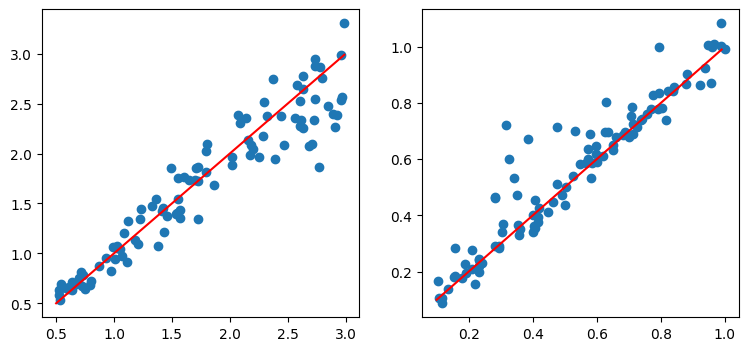

In [10]:
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))

print(r2_score(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold), 
      r2_score(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt))

print(pearsonr(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)[0], 
      pearsonr(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)
plt.plot(np.arange(0.5, 3, 0.01), np.arange(0.5, 3, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)
plt.plot(np.arange(0.1, 1, 0.01), np.arange(0.1, 1, 0.01), c='red');

437/437 [==============================] - 0s 270us/step
0.8760220911257375 0.8629297376634889
0.937228936451321 0.9305202490292108


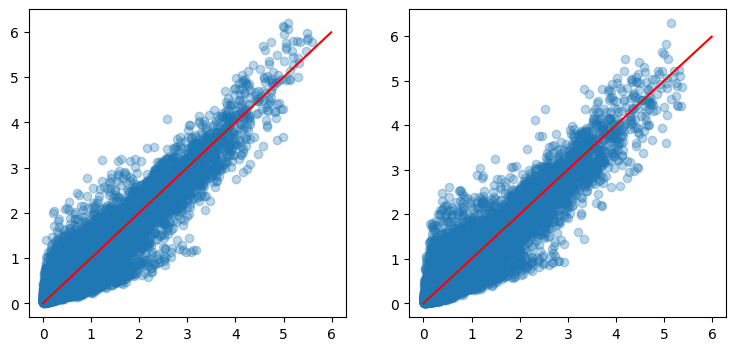

In [11]:
pred_v = model.predict(X_train)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in tr_df['sbj']])

print(r2_score(tr_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(tr_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(tr_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(tr_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

188/188 [==============================] - 0s 270us/step
0.8659144722045838 0.8569359156502591
0.9320429885582044 0.927239915230379


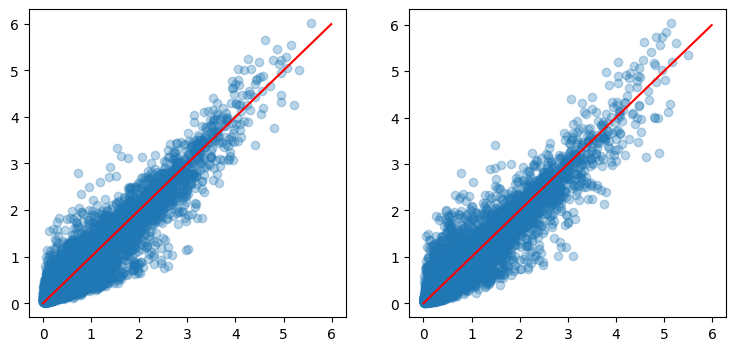

In [12]:
pred_v = model.predict(X_test)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

print(r2_score(ts_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(ts_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(ts_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(ts_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(ts_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(ts_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');